# Data Analysis of Products

This notebook allows to explore and analyze the data of products processed by our CSV processor.

## Initial Setup

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from src.processors.csv_processor import CSVProcessor

# Settings for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Resize the columns to display all the content
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

## Load and Treat Data

In [7]:
# Set the paths
project_root = Path().absolute().parent
input_path = project_root / "data" / "raw" / "input.csv"
output_path = project_root / "data" / "processed" / "output.csv"

# Treat the data
processor = CSVProcessor(str(input_path), str(output_path))
df = processor.process_csv()

print(f"Total number of products : {len(df)}")
df.head()

2024-10-28 16:33:27,829 - INFO - Reading CSV file: C:\Users\Theo\PycharmProjects\meal-planner\data\raw\input.csv
2024-10-28 16:33:27,882 - INFO - Sample of original prices:
2024-10-28 16:33:27,883 - INFO - 0    2                                             ...
1    2                                             ...
2    2                                             ...
3    9                                             ...
4    9                                             ...
Name: product-price-unit, dtype: object
2024-10-28 16:33:28,097 - INFO - Sample of cleaned prices:
2024-10-28 16:33:28,097 - INFO - 0    2.89
1    2.89
2    2.89
3    9.39
4    9.39
Name: product-price-unit, dtype: float64
2024-10-28 16:33:28,109 - INFO - Removed 3843 duplicate entries.
2024-10-28 16:33:28,111 - INFO - Processed 10057 products with 19 missing unit prices and 3939 missing kilogram prices.
2024-10-28 16:33:28,156 - INFO - Processed file saved to: C:\Users\Theo\PycharmProjects\meal-planner\data\proce

Total number of products : 10057


,product-name,product-price-unit,product-price-kilogram,product-origin
0,Café capsules L'OR Espresso Or Absolu n°9 - x1...,2.89,55.58,NaN
1,Café capsules L'OR Espresso Lungo Mattinata n°...,2.89,55.58,NaN
2,Café capsules L'OR Espresso Or Rose n°7 - x10 ...,2.89,55.58,NaN
3,Capsules Café Royal Espresso - x36 - 190g,9.39,49.42,NaN
4,Capsules Café Royal Espresso Forte - x36 - 190g,9.39,49.42,NaN


## Analyze the prices

### Price Distribution

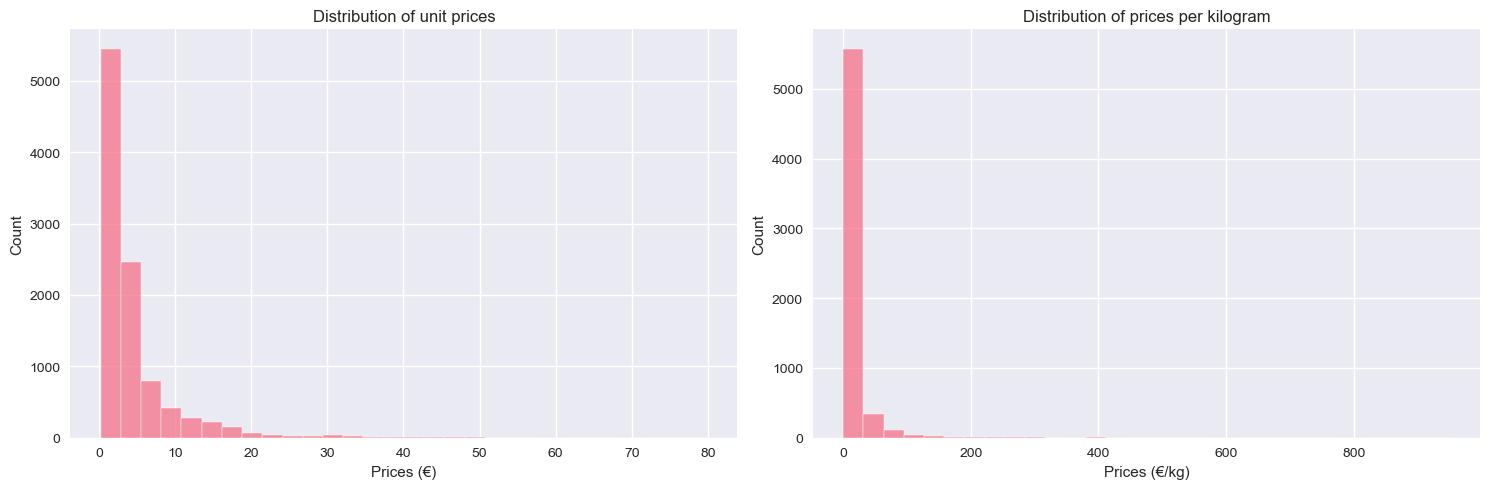


Statistics of prices :
       Prix Unitaire   Prix au Kg
count   10038.000000  6118.000000
mean        4.626389    15.383323
std         5.754506    32.227484
min         0.240000     0.020000
25%         1.790000     4.732500
50%         2.690000     8.235000
75%         4.827500    14.400000
max        79.900000   950.000000


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of unit prices
sns.histplot(data=df, x='product-price-unit', bins=30, ax=ax1)
ax1.set_title('Distribution of unit prices')
ax1.set_xlabel('Prices (€)')

# Distribution of prices per kilogram
sns.histplot(data=df, x='product-price-kilogram', bins=30, ax=ax2)
ax2.set_title('Distribution of prices per kilogram')
ax2.set_xlabel('Prices (€/kg)')

plt.tight_layout()
plt.show()

# Statistics of prices
print("\nStatistics of prices :")
stats = pd.DataFrame({
    'Prix Unitaire': df['product-price-unit'].describe(),
    'Prix au Kg': df['product-price-kilogram'].describe()
})
print(stats)

### Top 10 most expensive products

In [9]:
# Top 10 of the most expensive products (unit price)
print("Top 10 of the most expensive products (unit price) :")
top_10_unit = df.nlargest(10, 'product-price-unit')[['product-name', 'product-price-unit']]
print(top_10_unit)

# Top 10 of the most expensive products (kg price)
print("\nTop 10 of the most expensive products (kg price) :")
top_10_kg = df.nlargest(10, 'product-price-kilogram')[['product-name', 'product-price-kilogram']]
print(top_10_kg)

Top 10 of the most expensive products (unit price) :
                                           product-name  product-price-unit
2361    Brosse à dents Electrique Oral-B - Rose - IO 3S               79.90
2353                    Brossettes Oral-B Pro Sensitive               64.95
3332                      Xls Medical Pro-7 180 gélules               64.37
3657                Sérum multi-correcteur Filorga 30ml               64.36
2350           Brossettes Oral-B Pro Cross action - x12               62.83
2362  Brosse à dents électrique Oral B power pro-sen...               59.30
3646  Super sérum anti-âge Nuxe Concentré universel ...               55.90
2352     Brosettes Oral-B Sensitive Sensitive Clean 2x4               52.42
2356        Brossettes Oral-B Bundle Cross Action 4+4+2               50.80
4589  Couches Pampers Premium Protection Taille 6 - x90               49.90

Top 10 of the most expensive products (kg price) :
                                            product-name  p

## Categories Analysis

We can try to extract categories from the product names

Number of products per categories :
category
crème         316
gel           217
fromage       187
biscuits      171
shampooing    153
dentifrice    139
lait          127
sauce         127
boisson       118
déodorant     118
Name: count, dtype: int64


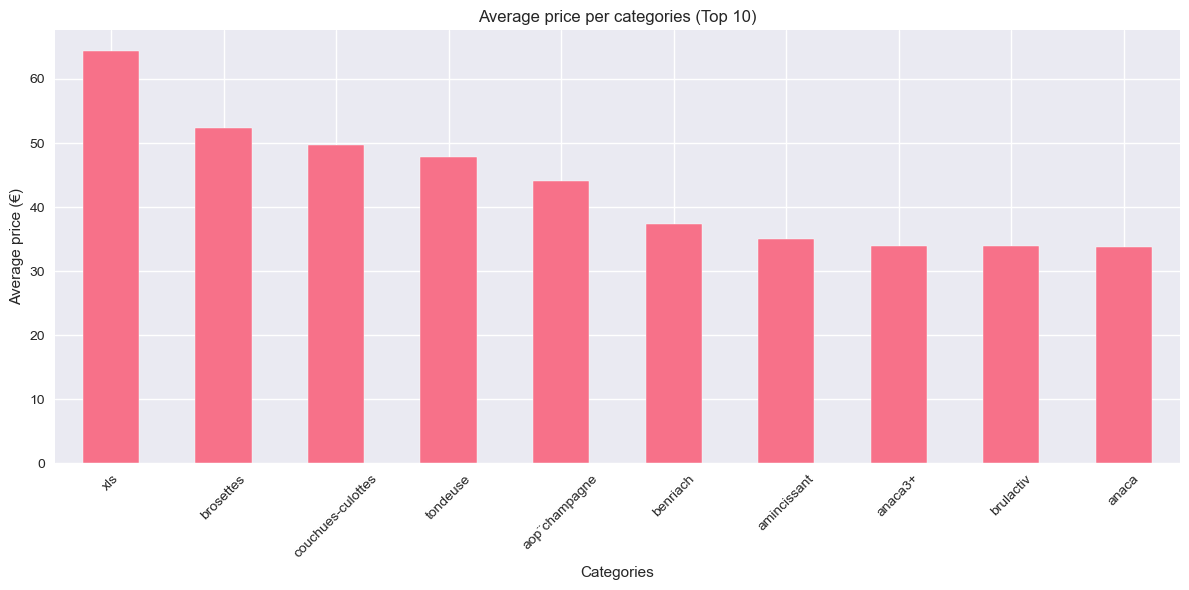

In [10]:
def extract_category(name):
    """Extract the category from the product name"""
    # Take the first word of the name as category
    return name.split()[0].lower()

df['category'] = df['product-name'].apply(extract_category)

# Draw the distribution of categories
category_counts = df['category'].value_counts()
print("Number of products per categories :")
print(category_counts.head(10))

# Visualizatino of the average prices per category
plt.figure(figsize=(12, 6))
category_prices = df.groupby('category')['product-price-unit'].mean().sort_values(ascending=False)
category_prices.head(10).plot(kind='bar')
plt.title('Average price per categories (Top 10)')
plt.xlabel('Categories')
plt.ylabel('Average price (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Prepare the Data for Integration with Gemini

Create a sample of data to test the integration with Gemini

In [11]:
# Create a sample of data for Gemini
sample_size = min(100, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

# Save the sample
sample_path = project_root / "data" / "processed" / "sample_for_gemini.csv"
df_sample.to_csv(sample_path, index=False)

print(f"Sample of {sample_size} products save at {sample_path}")
print("\nPreview of the sample :")
df_sample.head()

Sample of 100 products save at C:\Users\Theo\PycharmProjects\meal-planner\data\processed\sample_for_gemini.csv

Preview of the sample :


,product-name,product-price-unit,product-price-kilogram,product-origin,category
11109,Pizza Merveillosa Turini Mozzarella - 335g,2.28,6.81,NaN,pizza
6809,Sucre en poudre Saint Louis 1kg,1.85,1.85,NaN,sucre
1259,Spray dégraissant Clair Savon noir - 750ml,1.09,NaN,NaN,spray
11608,Macédoine Menu Fraîcheur Légumes - 300g,1.75,5.83,NaN,macédoine
109,Mélange Cocktail Tokapi Ananas et raisins - 120g,1.55,12.92,NaN,mélange
